## IMPORT PACKAGES

In [1]:
import pandas as pd
import sys
from matplotlib import pyplot as plt
import pickle
import numpy as np

sys.path.append('../../')
from utils import microarray_utils, clustering_utils, bokeh_ui_utils, file_utils

/Users/michaelbertagna/anaconda3/envs/cdh2_bokeh.env/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/michaelbertagna/anaconda3/envs/cdh2_bokeh.env/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/michaelbertagna/anaconda3/env

In [2]:
full_filtered_df = pd.read_csv('../microarray_probe_alignment_and_filtering/allgood_filt_agg_tidy_2021aligned_qc_rma_expression_full.csv')
full_filtered_df = full_filtered_df.rename(columns={'Unnamed: 0': 'TTHERM_ID'})
full_filtered_norm_df = microarray_utils.normalize_expression_per_gene(full_filtered_df, z=True)
full_filtered_norm_df = microarray_utils.get_arith_mean_expression(full_filtered_norm_df)

num_genes = full_filtered_df.shape[0]
num_genes

20426

In [3]:
veg_cols = [col for col in full_filtered_norm_df.columns if col[0] != 'C']
veg_filtered_df = full_filtered_df[veg_cols]
veg_filtered_norm_df = microarray_utils.normalize_expression_per_gene(veg_filtered_df, z=True)
veg_filtered_norm_df.head()

KeyError: "['Ll', 'Lm', 'Lh', 'S0', 'S3', 'S6', 'S9', 'S15', 'S24'] not in index"

In [ ]:
np.min(veg_filtered_norm_df[veg_cols[1:]])

-4.276733175117662

In [ ]:
sex_cols = [col for col in full_filtered_norm_df.columns if col[0] == 'C']
sex_filtered_df = full_filtered_df[['TTHERM_ID'] + sex_cols]
sex_filtered_norm_df = microarray_utils.normalize_expression_per_gene(sex_filtered_df, z=True)
sex_filtered_norm_df.head()

,TTHERM_ID,C0_GSM285570,C0_GSM656230,C4_GSM285574,C4_GSM285588,C4_GSM656234,C6_GSM285575,C6_GSM656232,C8_GSM285576,C8_GSM285590,...,C12_GSM656237,C14_GSM285580,C14_GSM285593,C14_GSM656238,C16_GSM285582,C16_GSM285595,C16_GSM656239,C18_GSM285583,C18_GSM285596,C18_GSM656240
0,TTHERM_00000010,2.716404,2.167527,-0.038687,-0.302160,-1.244960,-0.472384,-1.903846,-0.514422,-0.814341,...,-0.508593,0.496686,0.543680,0.451643,0.243567,0.681949,0.185777,0.631139,0.521819,0.103088
1,TTHERM_00000020,3.003378,0.036712,-1.485994,0.224492,2.354906,-0.206269,-0.201082,-0.231885,-0.441471,...,-0.370634,-0.742076,0.273668,-0.346899,-0.386280,1.681331,-0.364359,-0.652774,-0.047117,-0.671293
2,TTHERM_00000030,2.679811,-0.543877,1.569297,2.099280,1.289337,-0.572715,0.651315,-0.519359,-0.857076,...,-0.846372,-0.091590,-0.899081,-0.183362,-0.478571,-0.582065,-1.277553,-0.336147,0.009814,-0.831795
3,TTHERM_00000040,1.595176,0.419261,0.886885,1.190418,0.973716,1.648741,0.959516,-0.438615,0.660182,...,-0.723134,-0.095664,-0.577595,-0.483448,0.209057,-0.013774,-0.385686,0.024291,0.332067,0.399817
4,TTHERM_00000047,-0.964618,-2.686980,1.142781,0.763879,-0.481909,0.131979,-0.645622,1.437926,1.191259,...,-0.580170,1.338609,1.043056,0.191058,-0.470968,0.027645,-1.131089,0.174671,-0.176019,-1.462728


In [ ]:
np.max(sex_filtered_norm_df[sex_cols[1:]])

4.406693096984925

In [ ]:
microarray_utils.get_arith_mean_expression(sex_filtered_norm_df)

,TTHERM_ID,C0,C4,C6,C8,C10,C12,C14,C16,C18
0,TTHERM_00000010,2.441966,-0.528602,-1.188115,-0.664381,-0.873432,-0.568538,0.497336,0.370431,0.418682
1,TTHERM_00000020,1.520045,0.364468,-0.203675,-0.336678,-0.422955,-0.317026,-0.271769,0.310231,-0.457062
2,TTHERM_00000030,1.067967,1.652638,0.039300,-0.688217,-0.327942,-0.156593,-0.391344,-0.779396,-0.386043
3,TTHERM_00000040,1.007219,1.017006,1.304128,0.110783,-1.809235,-1.228625,-0.385569,-0.063468,0.252058
4,TTHERM_00000047,-1.825799,0.474917,-0.256821,1.314592,-0.319975,0.405673,0.857574,-0.524804,-0.488025
...,...,...,...,...,...,...,...,...,...,...
20421,TTHERM_02653492,0.252140,-1.092650,-1.076039,-0.350495,-1.119245,-0.013761,0.933440,0.736740,0.965324
20422,TTHERM_02653502,1.154388,0.256249,0.924420,-1.046924,-1.152435,-1.207774,-0.128334,0.643462,0.516763
20423,TTHERM_02653508,-0.808111,-0.640378,-1.081806,0.088139,-0.139339,-0.790740,0.908930,0.959877,0.856388
20424,TTHERM_02653514,-0.641124,0.285299,0.096467,0.533389,1.151889,-0.286675,-1.214696,-0.071096,0.526754


In [ ]:
# import numpy as np
# import scipy.stats as st

# def normalizer(array):
#     """
#     Normalizes the values of an array to range from zero to one
#     """
    
#     a = np.array(array)
    
#     normalized = (array - np.min(array)) / (np.max(array) - np.min(array))
    
#     return normalized


# def z_normalizer(array):

#     """
#     Normalizes the values of an array to z-score from mean
#     """

#     # log_a = [np.log10(expr) for expr in array]
#     normalized = pd.Series(st.zscore(array))
#     return normalized


# def normalize_expression_per_gene(expression_df, z=False):
#     """
#     Function to normalize all gene expression to range from zero to one.
#     """
#     if 'TTHERM_ID' in expression_df.columns:
#         ttids = expression_df['TTHERM_ID'].values
#         data = expression_df[list(expression_df.columns)[1:]]

#         columns = expression_df.columns.tolist()

#         if z:
#             norm_expression_df = data.apply(lambda row: z_normalizer(row), axis=1)
#             norm_expression_df.columns = columns[1:]
        
#         else:
#             norm_expression_df = data.apply(lambda row: normalizer(row), axis=1)
        
#         norm_expression_df['TTHERM_ID'] = ttids
#         # norm_expression_df.columns = columns
        
        
#         columns = norm_expression_df.columns.tolist()
        
#         rearrangment = columns[-1:] + columns[:-1]
        
#         norm_expression_df = norm_expression_df[rearrangment]
        
#     else:

#         if z:
#             norm_expression_df = data.apply(lambda row: z_normalizer(row), axis=1)
#             norm_expression_df.columns = columns

#         else:
#             norm_expression_df = expression_df.apply(lambda row: normalizer(row), axis=1)
    
#     return norm_expression_df

In [ ]:
# expression_df = full_filtered_df
# data = expression_df[list(expression_df.columns)[1:]]
# ttids = expression_df['TTHERM_ID'].values
# columns = expression_df.columns.tolist()

In [ ]:
# normalize_expression_per_gene(full_filtered_df, z=True)

In [ ]:
# columns

In [ ]:
# data.apply(lambda row: normalizer(row), axis=1)

In [ ]:
# data.apply(lambda row: z_normalizer(row), axis=1)

In [ ]:
# import numpy as np
# import scipy.stats as st

# def get_arith_mean_expression(expression_df):
#     """
#     Function to take an expression dataframe from the microarrays and collapse it into the means of
#     all replicate chips.
#     """
#     # C2 and S12 got removed during quality control
#     x = [
#         'Ll', 
#         'Lm', 
#         'Lh', 
#         'S0', 
#         'S3', 
#         'S6', 
#         'S9', 
#         # 'S12', 
#         'S15', 
#         'S24', 
#         'C0', 
#         # 'C2', 
#         'C4', 
#         'C6', 
#         'C8', 
#         'C10', 
#         'C12', 
#         'C14', 
#         'C16', 
#         'C18']
    
#     # cols = expression_df.columns[1:]
#     # x = [c for c in x if c in cols]
    
#     condition_expr_dict = {c.split("_")[0]: [] for c in expression_df.columns[1:]}
    
#     for c in list(expression_df.columns)[1:]:
        
#         cond = c.split('_')[0]
#         if cond in condition_expr_dict.keys():
#             expr_list = condition_expr_dict.get(cond, [])

#             # Need to avoid true zeros
#             expr_list.append(expression_df[c].values)
#             condition_expr_dict[cond] = expr_list
        
#     condition_mean_dict = {c: np.mean(np.array(condition_expr_dict[c]), axis=0) for c in condition_expr_dict.keys() if c in x}
    
#     mean_expr_df = pd.DataFrame(condition_mean_dict)
#     mean_expr_df['TTHERM_ID'] = expression_df['TTHERM_ID'].values
#     cols = list(mean_expr_df.columns)
#     reorder = cols[-1:] + cols[:-1]
#     mean_expr_df = mean_expr_df[reorder]
    
#     return mean_expr_df

# def get_geom_mean_expression(expression_df):
#     """
#     Function to take an expression dataframe from the microarrays and collapse it into the means of
#     all replicate chips.
#     """
#     # C2 and S12 got removed during quality control
#     x = [
#         'Ll', 
#         'Lm', 
#         'Lh', 
#         'S0', 
#         'S3', 
#         'S6', 
#         'S9', 
#         # 'S12', 
#         'S15', 
#         'S24', 
#         'C0', 
#         # 'C2', 
#         'C4', 
#         'C6', 
#         'C8', 
#         'C10', 
#         'C12', 
#         'C14', 
#         'C16', 
#         'C18']
    
#     # cols = expression_df.columns[1:]
#     # x = [c for c in x if c in cols]
    
#     condition_expr_dict = {c.split("_")[0]: [] for c in expression_df.columns[1:]}
    
#     for c in list(expression_df.columns)[1:]:
        
#         cond = c.split('_')[0]
#         if cond in condition_expr_dict.keys():
#             expr_list = condition_expr_dict.get(cond, [])

#             # Need to avoid true zeros
#             expr_list.append(expression_df[c].values)
#             condition_expr_dict[cond] = expr_list
        
#     condition_mean_dict = {c: (st.mstats.gmean(np.array(condition_expr_dict[c]) + 1, 0) - 1) for c in condition_expr_dict.keys() if c in x}
    
#     mean_expr_df = pd.DataFrame(condition_mean_dict)
#     mean_expr_df['TTHERM_ID'] = expression_df['TTHERM_ID'].values
#     cols = list(mean_expr_df.columns)
#     reorder = cols[-1:] + cols[:-1]
#     mean_expr_df = mean_expr_df[reorder]
    
#     return mean_expr_df

In [ ]:
# expression_df = full_filtered_norm_df

# x = [
#     'Ll', 
#     'Lm', 
#     'Lh', 
#     'S0', 
#     'S3', 
#     'S6', 
#     'S9', 
#     # 'S12', 
#     'S15', 
#     'S24', 
#     'C0', 
#     # 'C2', 
#     'C4', 
#     'C6', 
#     'C8', 
#     'C10', 
#     'C12', 
#     'C14', 
#     'C16', 
#     'C18']

# condition_expr_dict = {c.split("_")[0]: [] for c in expression_df.columns[1:]}

# for c in list(expression_df.columns)[1:]:
    
#     cond = c.split('_')[0]
#     if cond in condition_expr_dict.keys():
#         expr_list = condition_expr_dict.get(cond, [])

#         # Need to avoid true zeros
#         expr_list.append(expression_df[c].values)
#         condition_expr_dict[cond] = expr_list
    
# condition_mean_dict = {c: np.mean(np.array(condition_expr_dict[c]), axis=0) for c in condition_expr_dict.keys() if c in x}

In [ ]:
# condition_mean_dict

In [ ]:
full_filtered_norm_df

,TTHERM_ID,Ll_GSM283687,Ll_GSM284355,Ll_GSM284362,Lm_GSM283690,Lm_GSM284357,Lm_GSM284363,Lh_GSM283691,Lh_GSM284360,Lh_GSM284364,...,C12_GSM656237,C14_GSM285580,C14_GSM285593,C14_GSM656238,C16_GSM285582,C16_GSM285595,C16_GSM656239,C18_GSM285583,C18_GSM285596,C18_GSM656240
0,TTHERM_00000010,-1.456697,-1.754823,-1.448741,-0.599140,-1.911594,-1.788707,-0.828531,-1.185857,-1.147811,...,-0.404003,0.348884,0.384080,0.315151,0.159315,0.487634,0.116034,0.449581,0.367708,0.054106
1,TTHERM_00000020,-1.084984,-1.140597,-0.814966,0.877593,-0.649411,-1.034544,1.861245,-1.271198,-0.865053,...,-0.520375,-0.792174,-0.048915,-0.503007,-0.531824,0.981127,-0.515784,-0.726828,-0.283645,-0.740379
2,TTHERM_00000030,-0.734531,-0.855128,-0.466402,-0.335583,-0.807913,-0.476686,0.431002,-0.876428,-0.637112,...,-0.733489,-0.466517,-0.752133,-0.498977,-0.603395,-0.640002,-0.886001,-0.553019,-0.430650,-0.728333
3,TTHERM_00000040,0.754507,-1.003510,-0.692125,1.728414,-0.713236,-0.032250,2.723689,-0.812784,-0.273764,...,-1.093529,-0.528804,-0.962543,-0.877811,-0.254555,-0.455103,-0.789825,-0.420844,-0.143845,-0.082870
4,TTHERM_00000047,0.300277,0.768146,0.279371,-0.023959,0.320092,0.610513,-0.995717,0.201601,-0.148196,...,-0.473133,1.835129,1.479583,0.454643,-0.341764,0.258060,-1.135880,0.434930,0.013055,-1.534836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20421,TTHERM_02653492,-0.894126,-1.250727,-0.849032,-0.436729,-0.718806,-0.953459,1.303077,1.089520,0.231486,...,-0.515246,1.894469,1.796962,0.098061,1.359136,1.657355,0.131100,1.756120,1.803270,0.334151
20422,TTHERM_02653502,0.733064,0.590828,0.967252,-0.870535,-0.613010,1.178489,-0.599685,1.185418,0.562163,...,-1.432106,-0.465128,-0.130601,-1.039451,0.279859,0.693387,-0.307553,-1.085123,0.739952,0.633150
20423,TTHERM_02653508,-0.140201,-2.152022,-0.061492,-1.090662,-1.456721,-0.189702,0.149704,-1.446127,-0.534804,...,-1.487000,0.984060,0.974121,-0.597507,0.759683,1.020968,-0.300485,0.424808,0.777915,0.034716
20424,TTHERM_02653514,1.257005,2.006176,-0.622954,0.244483,0.006870,1.000267,-0.584525,1.788240,-0.298193,...,-0.618596,-0.863483,-0.784677,-1.552428,-0.230276,0.410152,-0.104018,0.499051,-0.864838,2.154503


In [ ]:
# get_arith_mean_expression(full_filtered_norm_df)

# LEIDEN CLUSTERING

In [10]:
phases_list = ['full', 'veg', 'sex']
phases = 'full'

In [3]:
metric = 'manhattan'
# metric='minkowski_3.0'

resolution_param=0.005
# resolution_param=0.0001

n_neighbors = 3

dataset = 'microarray'

In [4]:
# Moving normalization from within the function to before the function
leiden_label_df_round_1, partition_stats, cluster_sizes, enriched_cluster_sizes =  clustering_utils.build_label_df(
    full_filtered_norm_df,
    dataset,
    metric=metric,
    n_neighbors=n_neighbors, 
    resolution_param=resolution_param, 
    partition_type = 'EXP', 
    n_jobs = -1, 
    random_state=42
    )

In [7]:
full_filtered_norm_df.head()

,TTHERM_ID,Ll,Lm,Lh,S0,S3,S6,S9,S15,S24,C0,C4,C6,C8,C10,C12,C14,C16,C18
0,TTHERM_00000010,-1.553420,-1.433147,-1.054066,0.955595,0.974208,1.325400,1.204091,-0.126947,0.366653,1.805770,-0.418988,-0.912919,-0.520678,-0.677242,-0.448898,0.349372,0.254328,0.290465
1,TTHERM_00000020,-1.013516,-0.268787,-0.091669,2.079191,0.866215,0.832948,0.205371,-0.597014,-0.349501,0.863108,0.017528,-0.398205,-0.495528,-0.558661,-0.481148,-0.448032,-0.022160,-0.583618
2,TTHERM_00000030,-0.685354,-0.540061,-0.360846,2.244454,0.907066,1.587792,1.090819,-0.324945,-0.503064,-0.056373,0.150430,-0.420220,-0.677549,-0.550117,-0.489509,-0.572542,-0.709799,-0.570667
3,TTHERM_00000040,-0.313709,0.327643,0.545714,1.074320,0.492955,-0.088858,0.308485,0.822506,0.903034,0.463793,0.472602,0.731013,-0.343001,-2.071022,-1.548472,-0.789719,-0.499827,-0.215853
4,TTHERM_00000047,0.449265,0.302215,-0.314104,-0.965057,-0.472782,-0.859882,-0.012660,-0.043277,0.261221,-1.971605,0.796121,-0.084149,1.806237,-0.160122,0.712822,1.256452,-0.406528,-0.362284


In [11]:
leiden_label_df_round_1_arranged = bokeh_ui_utils.arrange_modules(full_filtered_norm_df, leiden_label_df_round_1, phases) 
leiden_label_df_round_1_arranged_sorted = leiden_label_df_round_1_arranged.sort_values(by=['label', 'TTHERM_ID'], ascending=False)
leiden_label_df_round_1_arranged_sorted.to_csv('./test_nn3_leiden_label_df_round_1.csv', index=False)

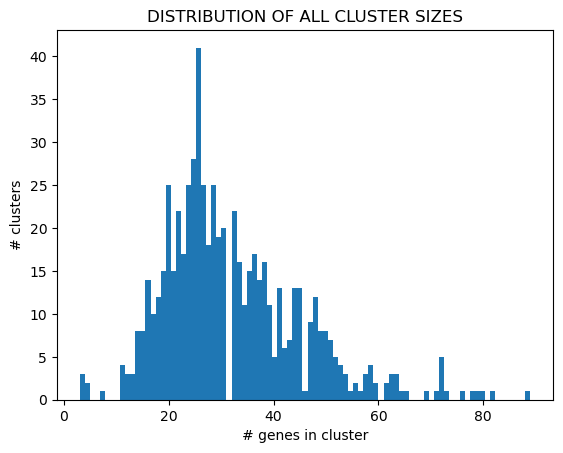

In [12]:
plt.hist(cluster_sizes, max(cluster_sizes))
plt.title('DISTRIBUTION OF ALL CLUSTER SIZES')
plt.xlabel('# genes in cluster')
plt.ylabel('# clusters')
plt.show()

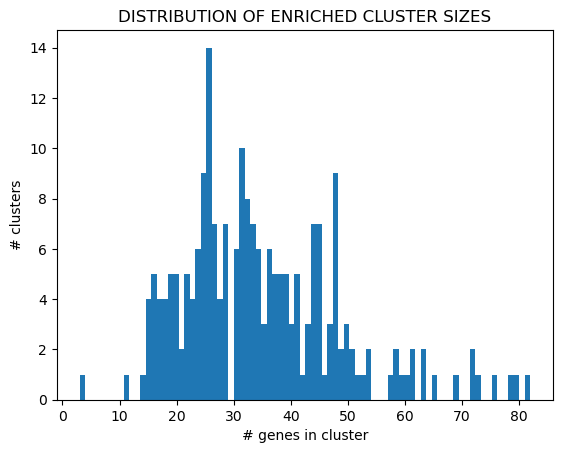

In [13]:
plt.hist(enriched_cluster_sizes, max(enriched_cluster_sizes))
plt.title('DISTRIBUTION OF ENRICHED CLUSTER SIZES')
plt.xlabel('# genes in cluster')
plt.ylabel('# clusters')
plt.show()

In [14]:
key_lens = [len(k) for k in partition_stats.keys()]
max_key_len = max(key_lens)

for k, v in partition_stats.items():
    print(f'{" " * (max_key_len - len(k))}{k}:', v)

              partition_type: EXP
              dimensionality: baseline
                      metric: manhattan
                       graph: umap_fuzzy_simplicial_set
                         nns: 3
                  clustering: leiden_cpm
                   parameter: 0.005
            silhouette_score: -0.03687461075696188
                  modularity: 0.761069349054897
                   nclusters: 636
           mean_cluster_size: 32.11635220125786
         median_cluster_size: 29.0
             sd_cluster_size: 13.204689343404809
          nenriched_clusters: 217
  mean_enriched_cluster_size: 34.86175115207373
median_enriched_cluster_size: 32.0
    sd_enriched_cluster_size: 14.050247637839645
     nenriched_cluster_genes: 7565
                    datetime: 2024-05-19 22:28:38.167236


In [15]:
enrich_full_nn3 = clustering_utils.compute_enrichment(leiden_label_df_round_1_arranged_sorted)

In [16]:
outfile='../enrichment/test_nn3_full_enrichment.csv'
enrich_full_nn3.to_csv(outfile, index=False)

In [17]:
complete_annot = pd.read_csv('../eggnog/complete_eggnog_annotation.csv')

In [18]:
palette45 = """
#51635F\n#FF1C16\n#16FC26\n#403DFC\n#FE0DCE\n#F9AA00\n#00FFD5\n#22BFFE\n#BB3551\n#E6FE97\n#ECADFF\n#FFBFBD\n#CF00F5\n#0D8B00\n#D7FEFF\n#8D7200\n#F76C00\n#AD3288\n#5C5AB8\n#FC0080\n#B8FF16\n#00AAB4\n#FBE11C\n#9AAAD9\n#8BBB8C\n#934B47\n#6EFE99\n#9C6D91\n#FB9778\n#9D32AF\n#D40087\n#FFDC9D\n#FF8DB6\n#A96AFC\n#FDDDFB\n#168CF7\n#FD6CF9\n#F64553\n#4D6A00\n#FAFEDB\n#A7977D\n#0DFBFF\n#86B80D\n#FD8AE4\n#B7B126
""".split()

palette32 = """
white\n#F91622\n#16FC0D\n#5138FB\n#FD00CF\n#FDD51C\n#16FDD7\n#FC8B8E\n#16BFFF\n#DF9BFD\n#669C2A\n#FEE7C4\n#F31685\n#DF16FD\n#C1F1FE\n#A23D7E\n#D5FD0D\n#8C5A0D\n#FC790D\n#4F5CBC\n#FFCBEF\n#168D72\n#68FA93\n#C4FDC9\n#F7A449\n#16789B\n#AD0DAB\n#C4262E\n#0DF1FF\n#EFF994\n#B6C1FE\n#8F22CD
""".split()

palette35 = """
#585F6A\n#FE1626\n#00FB0D\n#2E40FC\n#FD0DCE\n#FCD200\n#F7868C\n#16FFDC\n#22BEFB\n#D28EF6\n#609000\n#FFE7C9\n#F51683\n#FF730D\n#CAFE16\n#AA3586\n#BEEEFD\n#BD00FA\n#895D22\n#FEC7F0\n#495AA1\n#73F995\n#229270\n#ED963B\n#F6FE97\n#C5FFD0\n#C50DC8\n#6993FF\n#C22A35\n#16ECFC\n#AA707E\n#7A3BCB\n#7C845C\n#358FAA\n#BDBAF6
""".split()

palette38 = """
#636265\n#F60D16\n#00F90D\n#3540FB\n#FD0DD0\n#FDDB0D\n#00FFE2\n#FA8884\n#2ABEFE\n#E5A3FF\n#518F00\n#FEFDD5\n#D51CFF\n#ED007F\n#A33879\n#96731C\n#C8FB16\n#C0ECFE\n#FBC1DA\n#5658BA\n#F96900\n#F69F1C\n#58FA9C\n#008E72\n#BA22B9\n#167D97\n#794D8A\n#CEFE9C\n#BB222E\n#954D45\n#00DCEF\n#FD66B0\n#B2FDD3\n#FDBD9F\n#A9B4F1\n#B371FE\n#849566\n#2A8EFF
""".split()

palette64 = """
white\n#FA002E\n#22FC22\n#221CFA\n#FF3DD6\n#FFDA00\n#00FEFB\n#F48684\n#CEB4FE\n#FFFFE5\n#0D933D\n#CC00F8\n#800D5D\n#F10084\n#22267A\n#0DADFF\n#CBFD71\n#9A761C\n#F96C00\n#6399A6\n#FFBCDA\n#8D0DA3\n#F79F26\n#00FFBF\n#A37CFB\n#F68EEB\n#720D0D\n#F163AA\n#7E926A\n#826386\n#B41C32\n#9BEBCE\n#E2DB83\n#56D4FA\n#E6E2FB\n#925D58\n#F7C3A7\n#62E970\n#220DBD\n#5583BB\n#7EA01C\n#CDFDB6\n#FD00FB\n#B30D97\n#F5FF00\n#DD77FD\n#4282FC\n#BBA6A4\n#0D8068\n#AB5F26\n#F7C26E\n#9EFE00\n#9B2EFD\n#C56887\n#FD3D68\n#ABF2FD\n#835FAC\n#FF16B1\n#325371\n#CA16CA\n#D26322\n#AFCFFE\n#91A1FA\nfloralwhite
""".split()

palette65 = """
white\ngainsboro\n#FA002E\n#22FC22\n#221CFA\n#FF3DD6\n#FFDA00\n#00FEFB\n#F48684\n#CEB4FE\n#FFFFE5\n#0D933D\n#CC00F8\n#800D5D\n#F10084\n#22267A\n#0DADFF\n#CBFD71\n#9A761C\n#F96C00\n#6399A6\n#FFBCDA\n#8D0DA3\n#F79F26\n#00FFBF\n#A37CFB\n#F68EEB\n#720D0D\n#F163AA\n#7E926A\n#826386\n#B41C32\n#9BEBCE\n#E2DB83\n#56D4FA\n#E6E2FB\n#925D58\n#F7C3A7\n#62E970\n#220DBD\n#5583BB\n#7EA01C\n#CDFDB6\n#FD00FB\n#B30D97\n#F5FF00\n#DD77FD\n#4282FC\n#BBA6A4\n#0D8068\n#AB5F26\n#F7C26E\n#9EFE00\n#9B2EFD\n#C56887\n#FD3D68\n#ABF2FD\n#835FAC\n#FF16B1\n#325371\n#CA16CA\n#D26322\n#AFCFFE\n#91A1FA\nfloralwhite
""".split()

In [19]:
palette36 = ["#FFFFFF", 
             "#E4E1E3", 
             "#F6222E", 
             "#FE00FA", 
             "#16FF32", 
             "#3283FE", 
             "#FEAF16", 
             "#B00068", 
             "#1CFFCE",
             "#90AD1C", 
             "#2ED9FF", 
             "#DEA0FD", 
             "#AA0DFE", 
             "#F8A19F", 
             "#325A9B", 
             "#C4451C", 
             "#1C8356", 
             "#85660D",
             "#B10DA1", 
             "#FBE426", 
             "#1CBE4F", 
             "#FA0087", 
             "#FC1CBF", 
             "#F7E1A0", 
             "#C075A6", 
             "#782AB6", 
             "#AAF400",
             "#BDCDFF", 
             "#822E1C", 
             "#B5EFB5", 
             "#7ED7D1", 
             "#1C7F93", 
             "#D85FF7", 
             "#683B79", 
             "#66B0FF", 
             "#3B00FB",
             "magenta"]

change index 5 to #778899. Change index 9 to #2F4F4F. Add #FF7F50. Change index 9 to #FFBCD9. Change index 14 to #DEA5A4

In [20]:
palette27 = ["#FFFFFF", 
             "#AA0DFE", 
             "#3283FE", 
             "#85660D", 
             "#782AB6", 
             "#778899", 
             "#1C8356", 
             "#16FF32", 
             "#F7E1A0", 
#              "#2F4F4F",
             "#FFBCD9", 
             "#C4451C", 
             "#DEA0FD", 
             "#FE00FA", 
#              "#325A9B", 
             "#FEAF16", 
             "#DEA5A4", 
             "#90AD1C", 
             "#F6222E",
             "#1CFFCE", 
             "#2ED9FF", 
             "#B10DA1", 
#              "#C075A6", 
#              "#FC1CBF", 
#              "#B00068", 
             "#FBE426", 
             "#FA0087",
             "#FF7F50"
            ]

In [21]:
with open(('colors_2000_1'), 'rb') as file:
    color_palette_raw = pickle.load(file)

color_palette = palette65

if len(color_palette_raw) >= max(leiden_label_df_round_1_arranged_sorted['label'].unique()) + 1:
    color_palette = color_palette_raw[:max(leiden_label_df_round_1_arranged_sorted['label'].unique()) + 1]

In [22]:
import numpy as np
cols = full_filtered_norm_df.columns
np.min(full_filtered_norm_df[cols[1:]].values)

-3.766495876146788

In [ ]:
# import numpy as np
# from bokeh.models import Button, ColumnDataSource, CustomJS
# from bokeh.plotting import Column, figure, show

# x = np.linspace(0, 20, 200)
# y = x**2

# source = ColumnDataSource(data=dict(x=x, y=y))

# p = figure(tools="xpan")
# p.line("x", "y", source=source)

# button = Button()
# button.js_on_click(
#     CustomJS(args={"xr": p.x_range, "yr": p.y_range, "source": source}, code="""
#         const i = Math.max(source.data.x.findIndex((x) => x > xr.start), 0)

#         const j0 = source.data.x.findIndex((x) => x > xr.end)
#         const j = j0 >= 0 ? j0 : source.data.x.length - 1

#         const ysub = source.data.y.slice(i, j)

#         yr.start = Math.min.apply(null, ysub);
#         yr.end = Math.max.apply(null, ysub);
#     """)
# )

# show(Column(p, button))

In [23]:
# yf_to_ttherm_map_df = pd.read_csv('../../new_raw_data/tgd2024/yf_ttherm_mapping_may2024.csv')
# yf_to_ttherm_map_df.rename(columns={'TTHERM_ID': 'TTHERM_IDs', 'YF_ID': 'TTHERM_ID'},inplace=True)
yf_to_ttherm_map_df = None

In [24]:
import os

embedding_metric='manhattan'

dashboard_path = file_utils.generate_uniquely_numbered_export_path('./plots/', 'dashboard', '.html', tags=['microarr', 'umap', metric, f'{n_neighbors}nn', f'{resolution_param}rp'])

p = bokeh_ui_utils.generate_and_save_umap(dashboard_path, full_filtered_norm_df, complete_annot, leiden_label_df_round_1_arranged_sorted, phases, color_palette, os.path.basename(dashboard_path), expr_min=-3, expr_max=3, n_neighbors=n_neighbors, embedding_metric=embedding_metric, yf_to_ttherm_map_df=yf_to_ttherm_map_df)

/Users/michaelbertagna/anaconda3/envs/cdh2_bokeh.env/lib/python3.8/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/Users/michaelbertagna/anaconda3/envs/cdh2_bokeh.env/lib/python3.8/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/Users/michaelbertagna/anaconda3/envs/cdh2_bokeh.env/lib/python3.8/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a fut

./plots/dashboard375_microarr_umap_manhattan_3nn_0.005rp.html


In [ ]:
def run_over_all_phases(metric='manhattan', 
                        resolution_param=0.005, 
                        n_neighbors=3,
                        dataset='microarray'
                        ):


    with open(('colors_2000_1'), 'rb') as file:
        color_palette_raw = pickle.load(file)

    color_palette = palette65

    complete_annot = pd.read_csv('../eggnog/complete_eggnog_annotation.csv')
    phases_list = ['full', 'veg', 'sex']

    full_filtered_df = pd.read_csv('../microarray_probe_alignment_and_filtering/allgood_filt_agg_tidy_2021aligned_qc_rma_expression_full.csv')

    full_filtered_df = full_filtered_df.rename(columns={'Unnamed: 0': 'TTHERM_ID'})

    full_filtered_norm_df = microarray_utils.normalize_expression_per_gene(full_filtered_df, z=True)

    veg_cols = [col for col in full_filtered_norm_df.columns if col[0] != 'C']
    veg_filtered_df = full_filtered_df[veg_cols]
    veg_filtered_norm_df = microarray_utils.normalize_expression_per_gene(veg_filtered_df, z=True)

    sex_cols = [col for col in full_filtered_norm_df.columns if col[0] == 'C']
    sex_filtered_df = full_filtered_df[['TTHERM_ID'] + sex_cols]
    sex_filtered_norm_df = microarray_utils.normalize_expression_per_gene(sex_filtered_df, z=True)

    metric = metric
    # metric='minkowski_3.0'

    resolution_param=resolution_param
    # resolution_param=0.0001

    n_neighbors = n_neighbors

    dataset = dataset



    for phase, df, ndf in zip(phases_list, [full_filtered_df, veg_filtered_df, sex_filtered_df], [full_filtered_norm_df, veg_filtered_norm_df, sex_filtered_norm_df]):

        leiden_label_df_round_1, partition_stats, cluster_sizes, enriched_cluster_sizes =  clustering_utils.build_label_df(
            df,
            dataset,
            metric=metric,
            n_neighbors=n_neighbors, 
            resolution_param=resolution_param, 
            partition_type = 'EXP', 
            n_jobs = -1, 
            random_state=42
        )

        
        leiden_label_df_round_1_arranged = bokeh_ui_utils.arrange_modules(
            full_filtered_norm_df, 
            leiden_label_df_round_1, 
            phases
        )

        leiden_label_df_round_1_arranged_sorted = leiden_label_df_round_1_arranged.sort_values(by=['label', 'TTHERM_ID'], ascending=False)

        leiden_label_df_round_1_arranged_sorted.to_csv('./test_nn3_leiden_label_df_round_1.csv', index=False)

        enrich_full_nn3 = clustering_utils.compute_enrichment(leiden_label_df_round_1_arranged_sorted)

        outfile='../enrichment/test_nn3_full_enrichment.csv'
        enrich_full_nn3.to_csv(outfile, index=False)

        embedding_metric='manhattan'

        dashboard_path = file_utils.generate_uniquely_numbered_export_path('./plots/', 'dashboard', '.html', tags=['microarr', 'umap', metric, f'{n_neighbors}nn', f'{resolution_param}rp'])

        if len(color_palette_raw) >= max(leiden_label_df_round_1_arranged_sorted['label'].unique()) + 1:
            color_palette = color_palette_raw[:max(leiden_label_df_round_1_arranged_sorted['label'].unique()) + 1]

        p = bokeh_ui_utils.generate_and_save_umap(dashboard_path, ndf, complete_annot, leiden_label_df_round_1_arranged_sorted, phase, color_palette, os.path.basename(dashboard_path), expr_min=-3, expr_max=3, n_neighbors=n_neighbors, embedding_metric=embedding_metric, yf_to_ttherm_map_df=yf_to_ttherm_map_df)

    

    
    

In [ ]:
run_over_all_phases()

/Users/michaelbertagna/anaconda3/envs/cdh2_bokeh.env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/michaelbertagna/git/TGNE-2022/TGNE/embedding/../../utils/bokeh_ui_utils.py:484: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hm_df['module'] = hover_data['module'].values


./plots/dashboard369_microarr_umap_manhattan_3nn_0.005rp.html


/Users/michaelbertagna/git/TGNE-2022/TGNE/embedding/../../utils/bokeh_ui_utils.py:484: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hm_df['module'] = hover_data['module'].values


./plots/dashboard370_microarr_umap_manhattan_3nn_0.005rp.html


/Users/michaelbertagna/git/TGNE-2022/TGNE/embedding/../../utils/bokeh_ui_utils.py:484: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hm_df['module'] = hover_data['module'].values


./plots/dashboard371_microarr_umap_manhattan_3nn_0.005rp.html


In [ ]:
mucocyst_cluster = [
'YF00036312.t1',
'YF00012829.t1',
'YF00000889.t1',
'TTHERM_00527180',
'TTHERM_00335830',
'YF00012830.t1',
'YF00009126.t1',
'YF00005954.t1',
'YF00005804.t1',
'TTHERM_01055600',
'TTHERM_00624720',
] # TTHERM_00630470: mucocyst gene with drastically different expression profile

In [ ]:
print(','.join(mucocyst_cluster))

YF00036312.t1,YF00012829.t1,YF00000889.t1,TTHERM_00527180,TTHERM_00335830,YF00012830.t1,YF00009126.t1,YF00005954.t1,YF00005804.t1,TTHERM_01055600,TTHERM_00624720


In [ ]:
clustering_utils.fraction_max_same_cluster_genes(mucocyst_cluster, leiden_label_df_round_1_arranged_sorted)

YF00036312.t1
YF00012829.t1
YF00000889.t1
YF00012830.t1
YF00009126.t1
YF00005954.t1
YF00005804.t1
1 / 1 = 1.0
            TTHERM_ID  label
6918  TTHERM_00335830    160
TTHERM_00335830


1.0